# HOW TO DETERMINE THE BEST CHANCE OF PRODUCING A POPULAR FILM
## 1. BUDGET
## 2. GENRE
## 3. RELEASE WINDOW

# Importing necessary libraries and creating data tables

In [3]:
import os
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import display, Markdown
import seaborn as sns
from src.make_db import create_movies_db
pd.options.display.float_format="{:.2f}".format

create_movies_db()
con = sqlite3.connect('data/movies.db')

imdb_title_principals table created successfully....
imdb_name_basic table created successfully....
imdb_title_crew table created successfully....
imdb_title_ratings table created successfully....
imdb_title_basics table created successfully....
imdb_title_akas table created successfully....
tn_movie_budgets table created successfully....
tmdb_movies table created successfully....
bom_movie_gross table created successfully....
rotten_tomatoes_critic_reviews table created successfully....
rotten_tomatoes_movies table created successfully....
Inserting data into the imdb_title_crew table....
Inserting data into the tmdb_movies table....
Inserting data into the imdb_title_akas table....
Inserting data into the imdb_title_ratings table....
Inserting data into the imdb_name_basics table....
Inserting data into the rotten_tomatoes_movies table....
Inserting data into the rotten_tomatoes_critic_reviews table....
Inserting data into the imdb_title_basics table....
Inserting data into the tn_mo

# Creating and Formatting the Dataframe

Imports and joins all useful data into a single dataframe as well as cleaning numerical data and creating necessary columns

In [4]:
df = pd.read_sql('''SELECT distinct id, release_date, movie, production_budget, domestic_gross, worldwide_gross, genres  
                    FROM tn_movie_budgets AS tn
                     JOIN imdb_title_basics AS imdb
                 ON tn.movie = imdb.primary_title
                    ;''', con)
#Joins tn_movie_budgets with imdb_title_basics on the title column.

df.genres = df.genres.str.split(',') #this performs the split on the same column of data
df = df.explode('genres') #this explodes the newly created column and saves it to a new df



df.drop_duplicates(subset=['genres', 'movie'], keep='last', inplace = True)
df['production_budget'] = df['production_budget'].str.replace(',', '', regex = True)
df['production_budget'] = df['production_budget'].str.replace('$', '', regex = True).astype(int)
df['domestic_gross'] = df['domestic_gross'].str.replace(',', '', regex = True)
df['domestic_gross'] = df['domestic_gross'].str.replace('$', '', regex = True).astype(int)
df['worldwide_gross'] = df['worldwide_gross'].str.replace(',', '', regex = True)
df['worldwide_gross'] = df['worldwide_gross'].str.replace('$', '', regex = True).astype(int)

##Cleans numerical data and sets it to integer typre. 
df.release_date = pd.to_datetime(df.release_date)
#df = df[(df['release_date'] >= '1990-01-01') & (df['release_date'] <= '2019-01-01')]
df['total_gross'] = df['worldwide_gross'] + df['domestic_gross']  
df = df[(df['total_gross'] > 0)]
#Creates total gross column combining domestic and foreign gross
df['net_profit'] = df['total_gross'] - df['production_budget']
#Creates net profit column subtracting budget from total gross,
df['return_on_investment'] = df['net_profit'] / df['production_budget']
# Createsreturn on investment dividing total gross by production budget

month = df['release_date'].apply(lambda x: x.month).astype(int)
year = df['release_date'].apply(lambda x: x.year).astype(int)
df['month'] = month
df['year'] = year
#Creates year and month columns from release date column.
df.loc[df.production_budget>0, 'film_size']='0-5m$'
df.loc[df.production_budget>5000000, 'film_size']='5m-45m$'
df.loc[df.production_budget>45000000, 'film_size']='45m$+'
#Creates film size column based on our 4-45m reccomendation
df.groupby('production_budget')
df['budget_bins'] = pd.cut(df['production_budget'], [0, 1000000, 5000000, 10000000, 15000000, 20000000, 50000000, 100000000, 200000000, 400000000, 500000000])
bud_size = pd.cut(df['production_budget'], [0, 5000000, 45000000, 500000000])
#Creates a wider array of grouped budget bins for bar plot analysis
df = df.drop([3496], axis=0)
#drops erroneously reported rows
df.sort_values(by='return_on_investment', ascending=False)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,genres,total_gross,net_profit,return_on_investment,month,year,film_size,budget_bins
3261,47,1942-08-13,Bambi,858000,102797000,268000000,Biography,370797000,369939000,431.16,8,1942,0-5m$,"(0, 1000000]"
3261,47,1942-08-13,Bambi,858000,102797000,268000000,Documentary,370797000,369939000,431.16,8,1942,0-5m$,"(0, 1000000]"
3494,77,1968-10-01,Night of the Living Dead,114000,12087064,30087064,Horror,42174128,42060128,368.95,10,1968,0-5m$,"(0, 1000000]"
3411,37,1978-10-17,Halloween,325000,47000000,70000000,Thriller,117000000,116675000,359.00,10,1978,0-5m$,"(0, 1000000]"
3411,37,1978-10-17,Halloween,325000,47000000,70000000,Horror,117000000,116675000,359.00,10,1978,0-5m$,"(0, 1000000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3253,36,2014-11-21,Food Chains,913000,0,176,Documentary,176,-912824,-1.00,11,2014,0-5m$,"(0, 1000000]"
3222,3,2015-12-11,American Hero,1000000,0,26,Action,26,-999974,-1.00,12,2015,0-5m$,"(0, 1000000]"
3222,3,2015-12-11,American Hero,1000000,0,26,Comedy,26,-999974,-1.00,12,2015,0-5m$,"(0, 1000000]"
3223,3,2015-12-11,American Hero,1000000,0,26,Music,26,-999974,-1.00,12,2015,0-5m$,"(0, 1000000]"


# Create Yearly Summary and Chart Film Industry Growth Since 2000

## Are films more profitable now than they have ever been?

In [5]:
df_summary=df.groupby('year').mean('total_gross')
df_summary.reset_index(inplace=True)
#creates a new table with one entry per year representing the average total gross of each year 

Text(0.5, 1.0, 'Average Worldwide Gross Earnings')

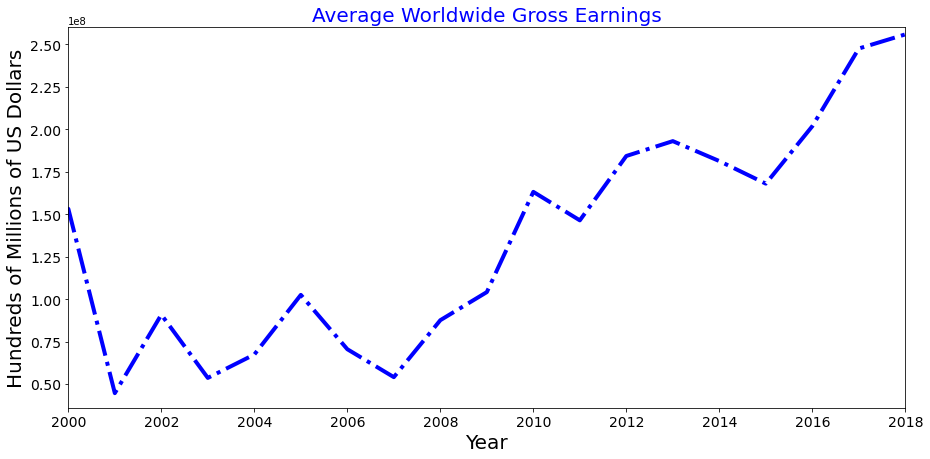

In [6]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(df_summary['year'], df_summary['total_gross'], color='blue', linewidth=4, linestyle='-.')
ax.ticklabel_format(axis='y', style = 'sci')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_xlabel('Year', fontsize=20)
ax.set_xlim(2000, 2018)  
#limits graph to years 2000 to 2018
ax.set_ylim(36000000, 260000000)
#limits y axis to remove white space
ax.set_ylabel('Hundreds of Millions of US Dollars', fontsize=20)
ax.set_title('Average Worldwide Gross Earnings', color='blue', fontsize=20)

## It appears as though now would be an increasingly profitable time to invest in the film industry.

In [7]:
df = df[(df['release_date'] >= '2010-01-01') & (df['release_date'] <= '2019-01-01')]

#Limits data to only films released from Jan 1, 2010 to Jan 1, 2019.

# How is budget related to net profit?

## predicting profit through scatterplot and regression line

Text(0.5, 0, 'Production Budget (Hundreds of Millions USD)')

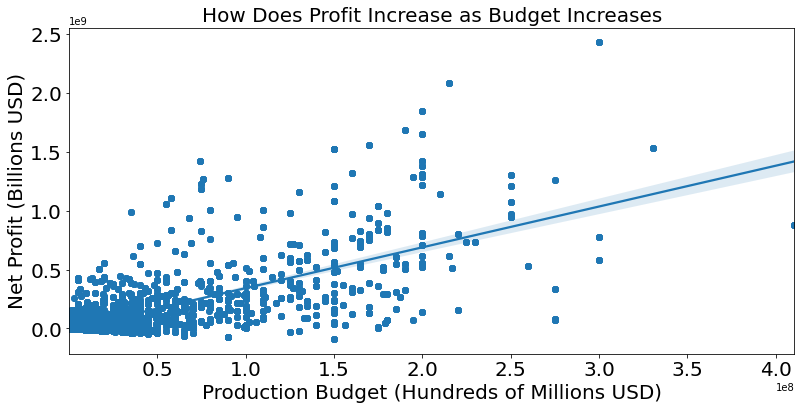

In [8]:
plot_one_fig, plot_one_ax = plt.subplots(figsize=(13,6))
plot_one_ax.scatter(df['production_budget'], df['net_profit'])
sns.regplot (data = df, x='production_budget', y= 'net_profit')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('How Does Profit Increase as Budget Increases', fontsize=20)
plt.ylabel('Net Profit (Billions USD)', fontsize=20)
plt.xlabel('Production Budget (Hundreds of Millions USD)', fontsize=20)

# Comparing ROI and Budget 

## How does a film's budget impact its likelyhood to return highly on its investment? i.e. the most profitable use of funds.

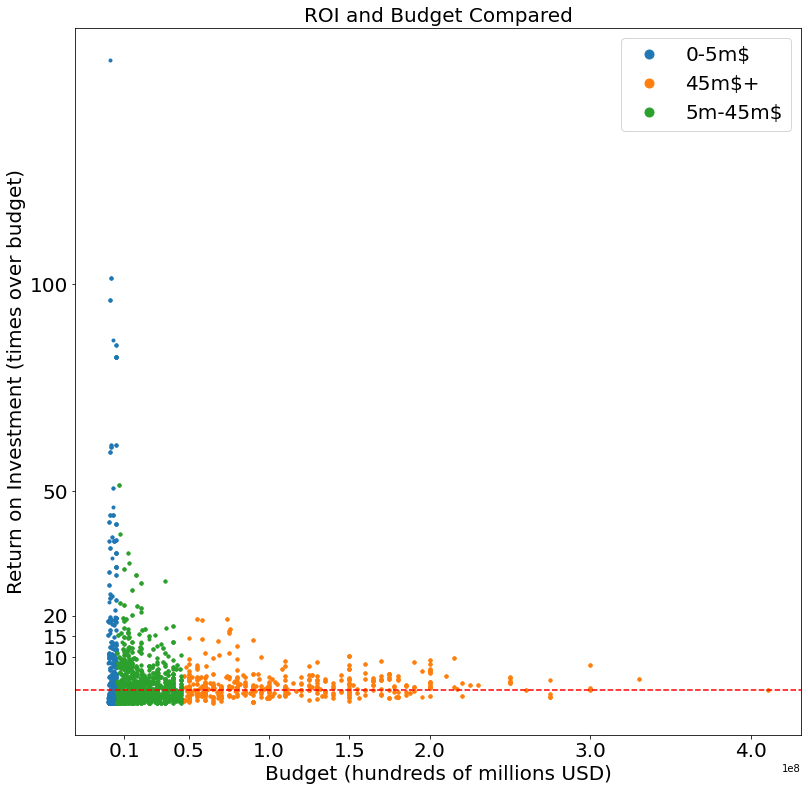

In [9]:
plot_two_fig, plot_two_ax = plt.subplots(figsize=(13,13))
groups = df.groupby("film_size")
for name, group in groups:
    plt.plot(group['production_budget'],  group['return_on_investment'], marker='.', linestyle="", label=name)
#X axis of budget y axis of RoI, grouped by budget
plt.yticks([10, 15, 20, 50, 100], fontsize=20)
plt.legend(loc='upper right', fontsize =20, markerscale= 3)
plt.title('ROI and Budget Compared', fontsize=20)
plt.ylabel('Return on Investment (times over budget)', fontsize=20)
plt.xlabel('Budget (hundreds of millions USD)', fontsize=20)
plt.xticks([10000000, 50000000, 100000000, 150000000, 200000000, 300000000, 400000000], fontsize =20)
plt.axhline(y=2, color='r', linestyle='--')
#draw horizontal line at 2x RoI or the point at which a film has made back its full marketing expenses and has begun making money
plt.ticklabel_format(useOffset=False, style='sci')

# Comparing ROI and net profit for the average 50% of films, noting which budget group each film falls into.

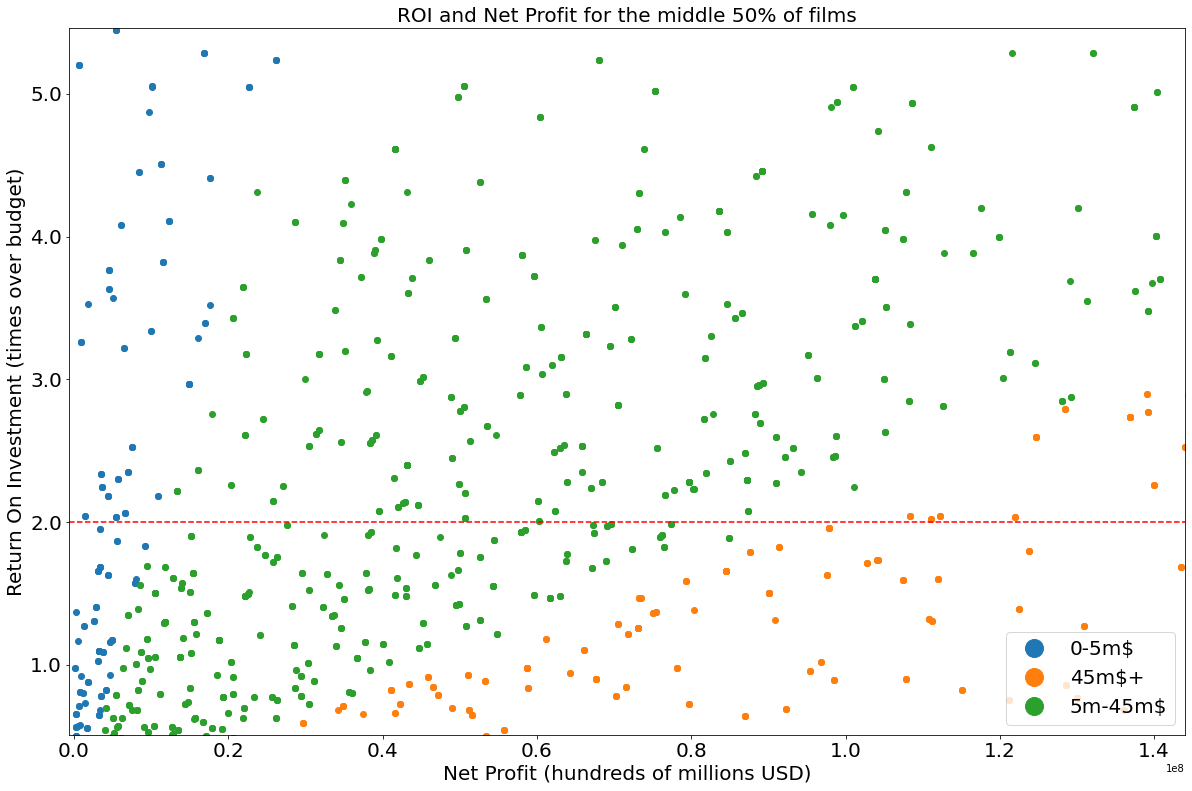

In [10]:
plot_three_fig, plot_three_ax = plt.subplots(figsize=(20,13))
df = df.sort_values(by = "return_on_investment", ascending=False)

for name, group in groups:
    plt.plot(group['net_profit'],  group['return_on_investment'], marker='o', linestyle="", label=name)
plt.legend(loc='lower right', fontsize =20, markerscale= 3)
plt.yticks([.5, 1, 2, 3, 4, 5], fontsize=20)
plt.ylim(.51, 5.46)
#sets y limits according to 25th and 75th percentile for return on investment
plt.title('ROI and Net Profit for the middle 50% of films', fontsize=20)
plt.ylabel('Return On Investment (times over budget)', fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Net Profit (hundreds of millions USD)', fontsize=20)
plt.xlim(-650000.00, 143991357.00)
#sets x limits according to 25th and 75th percentile for net profit
plt.axhline(y=2, color='r', linestyle='--')
#sets horizontal line where films become profitable
plt.ticklabel_format(useOffset=False, style='sci')

# Define function for determining probability of achieving given return on investment

## Does doubling a film's budget double its chance of returning on investment?

In [11]:
grouped_bins =  df.groupby(df.budget_bins)['production_budget'].agg(['count'])
def probability(df, num):
    probabilities = {}
    bins = df.budget_bins.unique()
    for bin_ in bins:       
        frame = df[(df.budget_bins == bin_) & (df.return_on_investment >= num)]
        total_in_budget_bin = grouped_bins.loc[bin_]['count']
        number_with_high_ri = frame.shape[0]
        probability = number_with_high_ri/total_in_budget_bin
        probabilities[bin_] = probability
    probabilities = dict(sorted(probabilities.items(), key=lambda x: x[0]))
    return probabilities
probabilities = probability(df, 2)
# calls function for an roi of 2
probabilities4 = probability(df, 4)
#calls function for an roi of 4

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

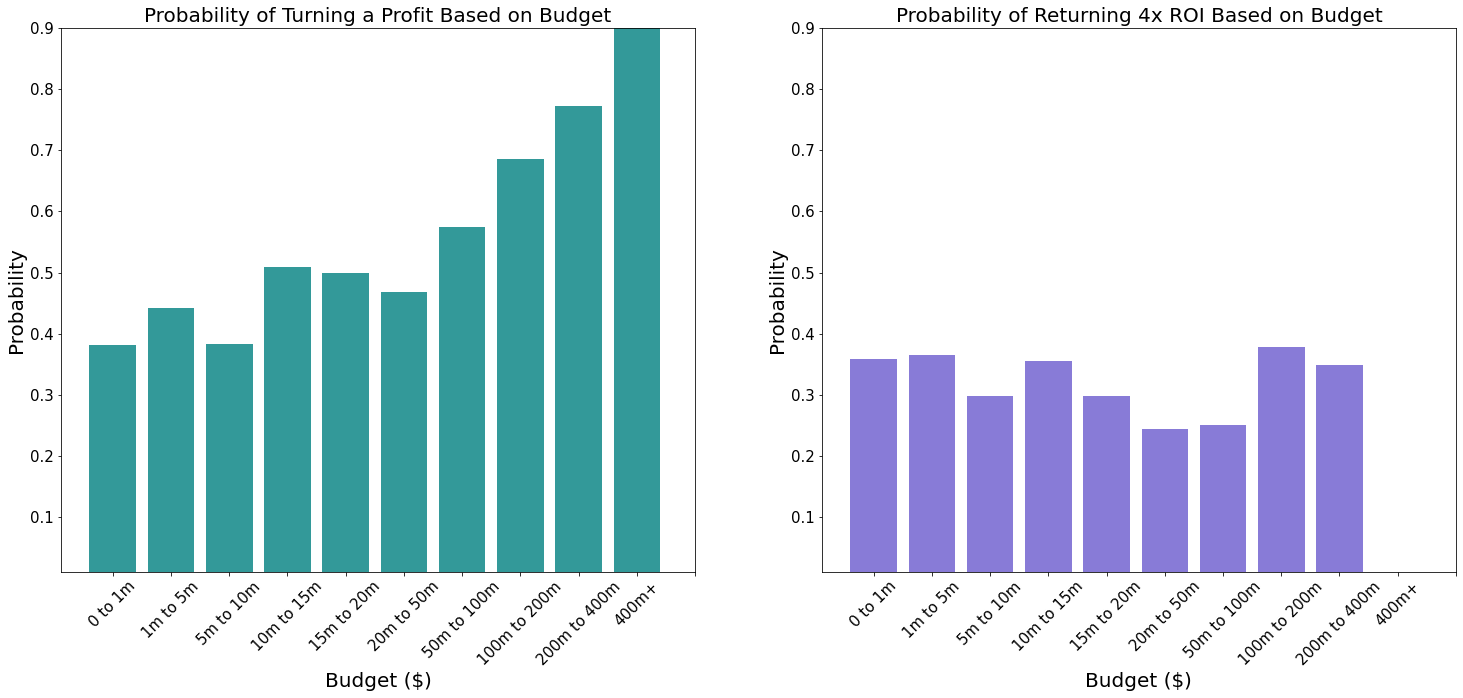

In [12]:
#sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(25,10))
plt.sca(ax[0])
plt.ylim(.01,.9)
ax[0].bar([f'{_.left}\nto\n{_.right}' for _ in probabilities], probabilities.values(), color='teal', alpha=.8)
ax[0].set_ylim(.01,.9)
ax[0].set_ylabel('Probability', fontsize=20)
ax[0].set_xlabel('Budget ($)', fontsize=20)
ax[0].set_title('Probability of Turning a Profit Based on Budget', fontsize=20)
ax[1].bar([f'{_.left}\nto\n{_.right}' for _ in probabilities4], probabilities4.values(), color='slateblue', alpha=.8)
ax[1].set_ylim(.01,.9)
ax[1].set_title('Probability of Returning 4x ROI Based on Budget', fontsize=20)
ax[1].set_ylabel('Probability', fontsize=20)
ax[1].set_xlabel('Budget ($)', fontsize=20)
plt.sca(ax[0])
plt.xticks([0,1, 2, 3,4,5,6,7,8,9, 10], ['0 to 1m', '1m to 5m', '5m to 10m', '10m to 15m', '15m to 20m', '20m to 50m', '50m to 100m', '100m to 200m', '200m to 400m', '400m+', ''], rotation=45, fontsize=15)
plt.yticks(fontsize = 15)
plt.sca(ax[1])
plt.xticks([0,1, 2, 3,4,5,6,7,8,9, 10], ['0 to 1m', '1m to 5m', '5m to 10m', '10m to 15m', '15m to 20m', '20m to 50m', '50m to 100m', '100m to 200m', '200m to 400m', '400m+', ''], rotation=45, fontsize=15)
plt.yticks(fontsize = 15)

## To double one's chance of return on investment beyond 50% one must invest 10x the budget from 10m to 100m+ dollars

# Create dataframes containing only small, medium, or large budget films

In [13]:
small_budget = df[(df['production_budget'] >= 5000000) & (df['production_budget'] <= 45000000)]
big_budget = df[(df['production_budget'] >= 45000000)]
mid_budget = df[df['film_size'] == '5m-45m$']

# Create function to return successful and unsuccessful films at varying budget ranges

In [14]:
def genre_wins(df):
    good_genres = df.genres.value_counts().index[:8].tolist()
    df = df[df.genres.isin(good_genres)]
    genre_wins = df[df.return_on_investment >= 2]
    return genre_wins
def genre_loss(df):
    good_genres = df.genres.value_counts().index[:8].tolist()
    df = df[df.genres.isin(good_genres)]
    genre_wins = df[df.return_on_investment <= 2]
    return genre_wins
big_wins=genre_wins(big_budget)
small_wins=genre_wins(small_budget)
mid_wins=genre_wins(mid_budget)
big_loss=genre_loss(big_budget)
small_loss=genre_loss(small_budget)
mid_loss=genre_loss(mid_budget)

# Determine what genres most successful 
## analyzing the most popular genres among films in our budget range that turned a profit

Text(0.5, 1.0, 'What genres are successful 5-45m$ films')

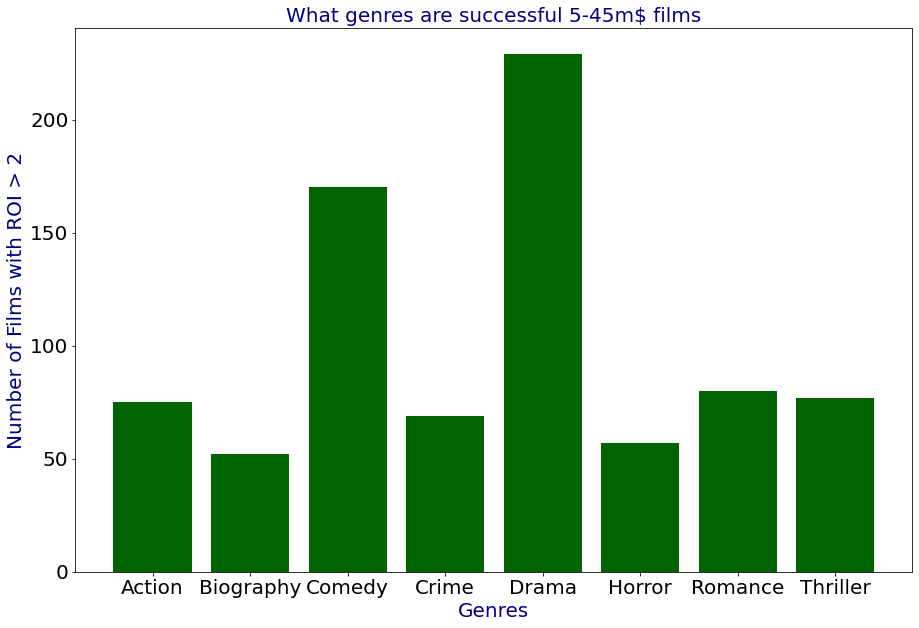

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(mid_wins.groupby('genres').count().id.index, mid_wins.groupby('genres').count().id, color='darkgreen') 
ax.set_xlabel('Genres', fontsize=20, color='navy')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, color='navy')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title('What genres are successful 5-45m$ films', color='navy', fontsize=20)

## Among 5-45m dollar films the most profitable genres are oscar-style dramas and low-brow comedies

Text(0.5, 1.0, 'What genres are successful 45m-400m$ films')

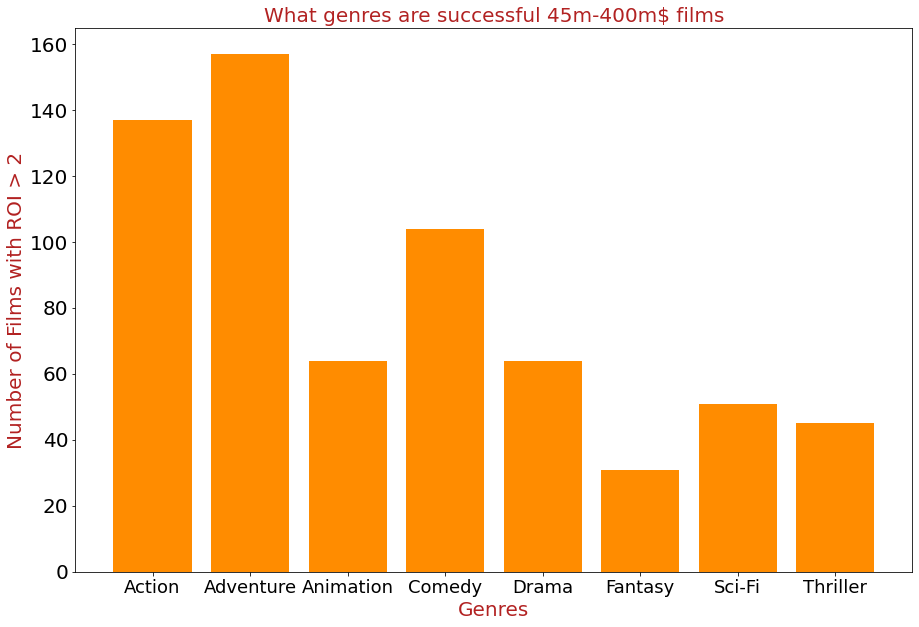

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(big_wins.groupby('genres').count().id.index, big_wins.groupby('genres').count().id, color='darkorange') 
ax.set_xlabel('Genres', fontsize=20, c='firebrick')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, c='firebrick')
plt.xticks(fontsize=18)
plt.yticks(fontsize=20)
ax.set_title('What genres are successful 45m-400m$ films', color='firebrick', fontsize=20)

## Among successful 45-400m dollar films, Action and Adventure are by far the most popular genre

# What seasonal window are the most profitable films released in?

Text(0.5, 1.0, 'What Month are Profitable Films with 45m-400m$ Budget Released')

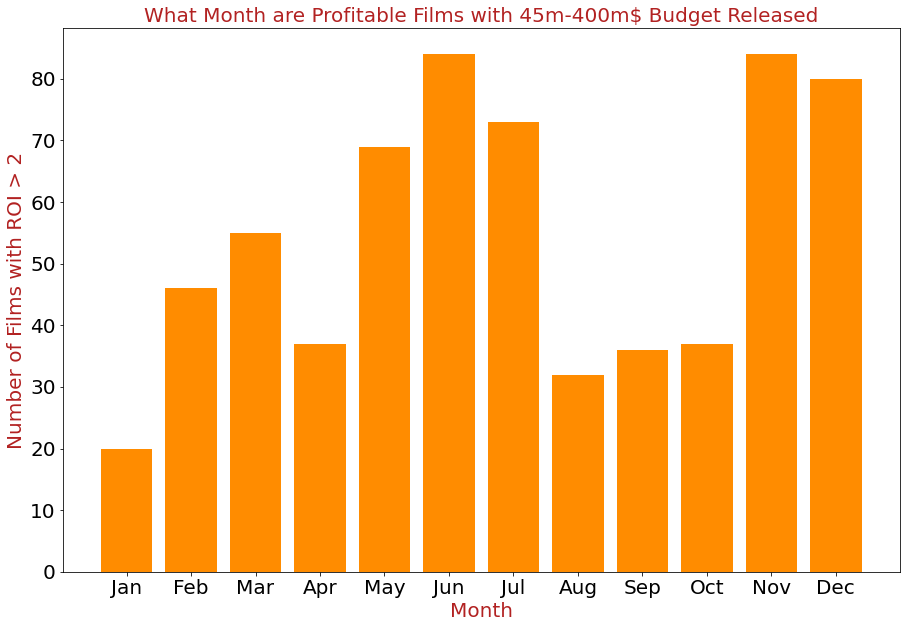

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(big_wins.groupby('month').count().id.index, big_wins.groupby('month').count().id, color='darkorange') 
ax.set_xlabel('Month', fontsize= 20, c='firebrick')
ax.set_ylabel('Number of Films with ROI > 2', fontsize = 20, c='firebrick')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize=20)
plt.yticks(fontsize=20)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('What Month are Profitable Films with 45m-400m$ Budget Released', color='firebrick', fontsize=20)

## Profitable 45-400m films are released largely during Summer and Winter months

Text(0.5, 1.0, 'What Month are Profitable Films with 5m-45m$ Budget Released')

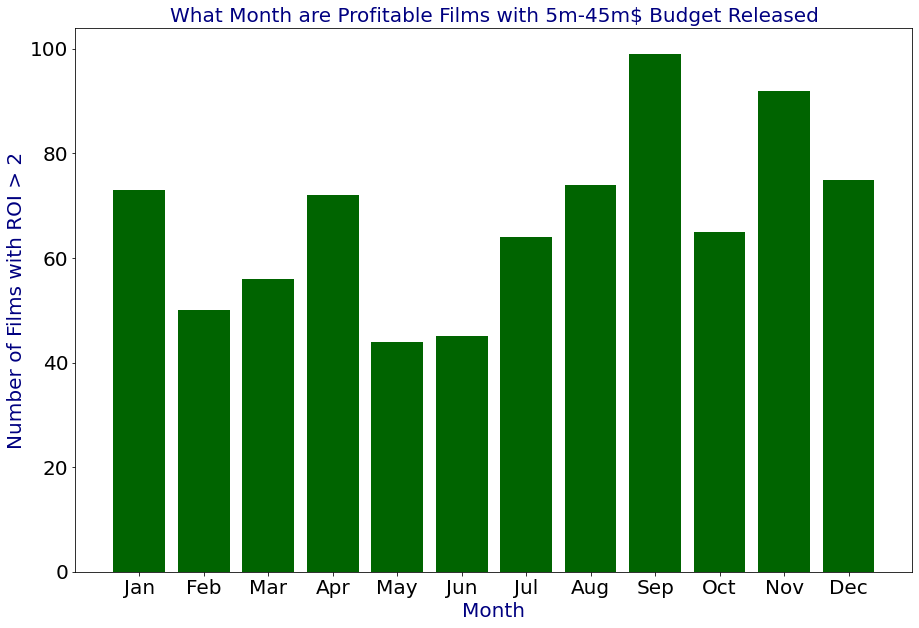

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ax.bar(mid_wins.groupby('month').count().id.index, mid_wins.groupby('month').count().id, color='darkgreen') 
ax.set_xlabel('Month', fontsize=20, c='navy')
ax.set_ylabel('Number of Films with ROI > 2', fontsize=20, c='navy')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], fontsize=20)
plt.yticks(fontsize=20)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('What Month are Profitable Films with 5m-45m$ Budget Released', color='navy', fontsize=20)

# Of profitable 5-45m dollar films, there appears a strong tendancy to avoid summer months and release films in September

# Conclusions.
## Though among single films, the likelyhood of returning investment is greatest among the largest blockbuster, the increase in risk is not proportional to the decrease in budget.  Producing multiple relatively 'cheap' 5-45m dollar films in addition to a single blockbuster can produce the greatest reward at the least risk